In [107]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import random

In [108]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [109]:
r_earth = 6371000
mu_earth = 3.986004418E+14
entry_interf_alt = 122000
m2ft = 0.3048

rad2deg = 57.2958

ap_range = np.linspace(150000, 1000000, 10)
incl = 40

In [133]:


def sma(ap, pe, r_earth):
    return (ap + pe + 2*r_earth)/2

def ecc(ap, pe, r_earth):
    return (ap - pe)/(ap + pe + 2*r_earth)

def eta_h(sma_, ecc_, h, r_earth):
    
    r = h + r_earth
    
    x = sma_*(1 - ecc_**2)/r
    
    cos_eta = (x - 1)/ecc_
    
    return np.arccos(cos_eta) * rad2deg

def fpa_h(sma_, ecc_, h, r_earth):
    
    eta_rad = eta_h(sma_, ecc_, h, r_earth)/rad2deg
    
    tan_phi = ecc_ * np.sin(eta_rad)/(1 + ecc_*np.cos(eta_rad))
    
    return np.arctan(tan_phi)*rad2deg

def vel_h(sma_, ecc_, h, mu_earth):
    
    r = h + r_earth
    
    return np.sqrt(mu_earth*(2/r - 1/sma_))

def correct_vi_incl(vi, incl, fpa, r_earth):

    vi_h = vi*np.cos(np.deg2rad(fpa))
    vi_t = vi*np.sin(np.deg2rad(fpa))
    
    #use average azimuth and average earth rotational vel given inclination

    sinincl = np.sin(np.deg2rad(incl))
    az_avg = np.arccos(2*sinincl/np.pi)

    vearth_avg = np.pi*r_earth*sinincl/43200

    ve_h = np.sqrt( vi_h**2 + vearth_avg**2 - 2*vearth_avg*vi_h*np.sin(az_avg))

    ve = np.sqrt(ve_h**2 + vi_t**2)
    
    return ve
    
    
def entry_interf_calc(ap, pe, incl, h):
    
    sma_ = sma(ap, pe, r_earth)
    ecc_ = ecc(ap, pe, r_earth)
    
    ei_vel = vel_h(sma_, ecc_, h, mu_earth)
    ei_fpa = fpa_h(sma_, ecc_, h, r_earth)

    ei_ve = correct_vi_incl(ei_vel, incl, ei_fpa, r_earth)
    
    return [ei_ve, -ei_fpa]

In [134]:
def steep_ei_fpa(ve):
    return 149.55 -0.035988*ve + 0.000002114297*ve**2

def ei_range_ve(ve):
    return 324664.498 -75.79*ve + 0.0044527*ve**2

def ei_range_fpa(fpa_):
    #fpa = 2.65*(theta*r_earth) - 4.5152
    
    return (fpa_/3 + 1.7038490566)*r_earth/1000

<Figure size 800x800 with 0 Axes>

(-2.4, -0.4)

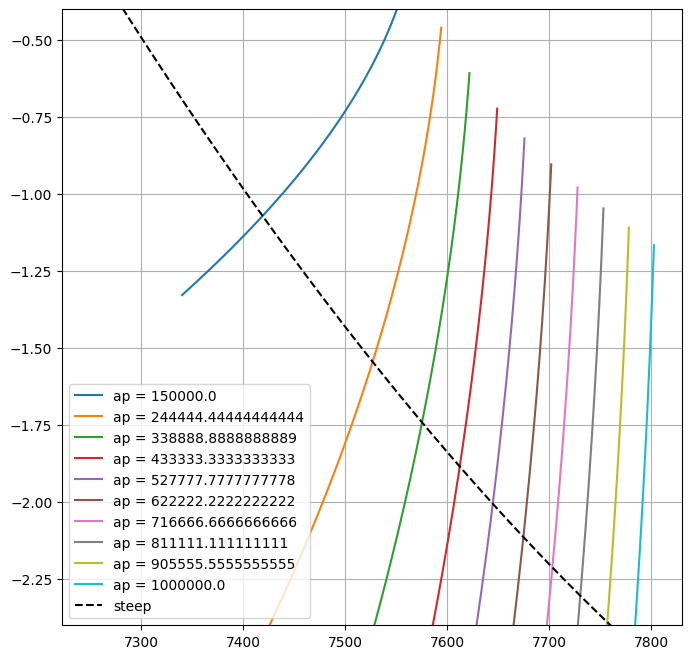

In [135]:
    

pe_range = np.arange(-600000, 100000, 500)  # Range of values for pe


results = [] 

for ap in ap_range:
    
    ei_ve = []
    ei_fpa = []

    for pe in pe_range:
        result = entry_interf_calc(ap, pe, incl, entry_interf_alt)
        ei_ve.append(result[0])
        ei_fpa.append(result[1])

    ei_ve = np.array(ei_ve)
    ei_fpa = np.array(ei_fpa)
    
    results.append([ei_ve, ei_fpa])
    

    
plt.figure(figsize=(8,8))
for i, ap_value in enumerate(ap_range):

    ei_ve = results[i][0]
    ei_fpa = results[i][1]

    # Plot the velocities
    _ = plt.plot(ei_ve, ei_fpa, label=f"ap = {ap_value}")

steep_v = np.arange(7250, 7800, 10)   
plt.plot(steep_v, steep_ei_fpa(steep_v), 'k--', label='steep' )
# Add a legend
plt.legend()
plt.grid()
plt.ylim([-2.4, -0.4])

# Show the plot
plt.show()

In [138]:


def ap_search_ei_solution(ap, incl):
    
    out = []
    
    pe_guess = 0
    
    fpa_error = -1
    
    iter_count = 0
    while abs(fpa_error) >= 0.005:
        iter_count += 1
        
        result = entry_interf_calc(ap, pe_guess, incl, entry_interf_alt)
        ei_ve = result[0]
        ei_fpa = result[1]
        
        out = [pe_guess, ei_ve, ei_fpa]
        
        steep_fpa = steep_ei_fpa(ei_ve)
        
        fpa_error = steep_fpa - ei_fpa
        
        pe_guess += fpa_error * 100000
      
    out.append(ei_range_ve(out[1]))
    return out


Text(0.5, 0, 'EI_vel')

Text(0, 0.5, 'EI_fpa')

Text(0.5, 0, 'EI_rng')

Text(0, 0.5, 'EI_fpa')

Text(0.5, 0, 'EI_vel')

Text(0, 0.5, 'EI_rng')

(-2.4, -0.4)

(-2.4, -0.4)

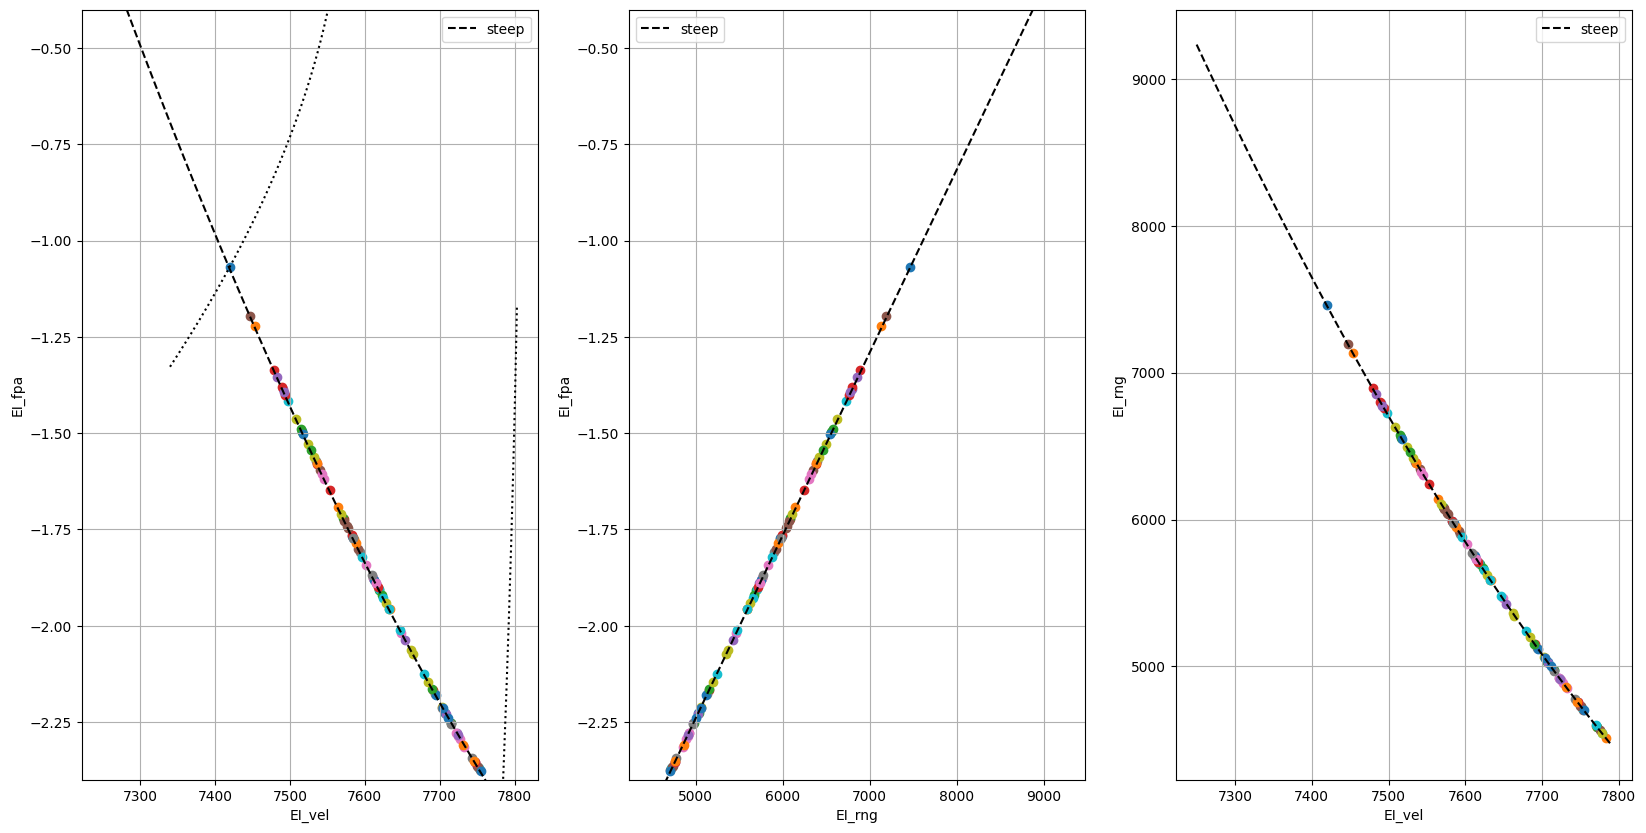

In [139]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))


steep_ve = np.arange(7250, 7800, 10)     
steep_fpa = steep_ei_fpa(steep_ve)
steep_rng = ei_range_ve(steep_ve)
ax1.plot(steep_v, steep_fpa, 'k--', label='steep' )
# Add a legend
ax1.legend()
ax1.grid()
ax1.set_xlabel("EI_vel")
ax1.set_ylabel("EI_fpa")

  
ax2.plot(steep_rng, steep_fpa, 'k--', label='steep' )
# Add a legend
ax2.legend()
ax2.grid()
ax2.set_xlabel("EI_rng")
ax2.set_ylabel("EI_fpa")

ax3.plot(steep_v, steep_rng, 'k--', label='steep' )
# Add a legend
ax3.legend()
ax3.grid()
ax3.set_xlabel("EI_vel")
ax3.set_ylabel("EI_rng")


ap_range = [150000, 1000000]

for ap in ap_range:
    
    ei_vel = []
    ei_fpa = []

    for pe in np.arange(-600000, 100000, 500):
        result = entry_interf_calc(ap, pe, incl, entry_interf_alt)
        ei_vel.append(result[0])
        ei_fpa.append(result[1])

    # Plot the velocities
    _ = ax1.plot(ei_vel, ei_fpa, 'k:')
    
ax1.set_ylim([-2.4, -0.4])
ax2.set_ylim([-2.4, -0.4])

#random values of ap
for _ in range(100):
    ap_range.append(random.randint(ap_range[0], ap_range[1]))

for ap in ap_range:
    out = ap_search_ei_solution(ap, incl)

    _ = ax1.scatter(out[1],out[2])
    
    _ = ax2.scatter(out[3],out[2])
    
    _ = ax3.scatter(out[1],out[3])

# Show the plot
plt.show()